In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
import sympy as sy
import scipy.constants as pc
from sympy import *

In [169]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (unsicherheiten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]+(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.2f}',
                   std_format='{1:!<4.2f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)

In [3]:
# Erinnerungen
# x = np.array([])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

[7.87796424e-02 1.50566596e-01 4.39904527e-02 6.07189420e-02
 1.56075020e-01 1.43648751e-17]
[2.53646813 2.11180773 1.73124347 1.1968652  0.76969697 0.11598746]


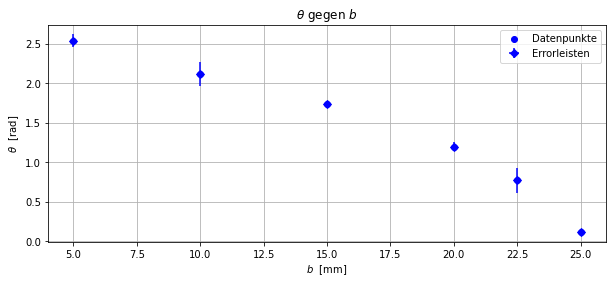

In [202]:
# Messdaten
b = np.array([5.0, 10.0, 15.0, 20.0, 22.5, 25.0])# mm (+- .5)
r_1 = 4.4 # .05

r_außen = 638.0/2.0 # +-1mm

s = np.array([[778.0, 787.0, 789.0, 797.0, 800.0, 801.0, 801.0, 802.0, 804.0, 805.0, 807.0, 818.0, 827.0, 840.0, 881.0],
              [578.0, 588.0, 646.0, 656.0, 661.0, 666.0, 667.0, 670.0, 670.0, 674.0, 710.0, 718.0, 726.0, 726.0, 749.0], 
              [510.0, 549.0, 548.0, 549.0, 550.0, 550.0, 550.0, 551.0, 552.0, 555.0, 556.0, 561.0, 563.0, 564.0, 576.0], 
              [332.0, 362.0, 367.0, 373.0, 377.0, 379.0, 381.0, 381.0, 382.0, 384.0, 398.0, 400.0, 401.0, 403.0, 407.0], 
              [113.0, 197.0, 198.0, 234.0, 238.0, 239.0, 251.0, 254.0, 258.0, 264.0, 267.0, 268.0, 280.0, 289.0, 333.0],
              [37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0]]) # mm (+- 1)

#s_25 = np.array([37.0])

#s_am = np.array([]) # mm (+- 1)
s_tot = r_außen*2.0*pc.pi # mm (+- 1)

#for el in s:
    #s_am = np.append(s_am, am(el))

theta = ((s*2.0*pc.pi)/s_tot) # rad
theta_am = np.array([]) # rad
theta_std = np.array([])

for el in theta:
    theta_am = np.append(theta_am, am(el))
    theta_std = np.append(theta_std, std(el))

#theta_am = np.append(theta_am, (s_25*2.0*pc.pi)/s_tot)
#theta_std = np.append(theta_std, 0)

print(theta_std)
print(theta_am)

cos_theta = np.cos(theta/2)

cos_theta_am =  np.array([])
cos_theta_std =  np.array([])

for el in cos_theta:
    cos_theta_am = np.append(cos_theta_am, am(el))
    cos_theta_std = np.append(cos_theta_std, std(el))
    
# Diagramm Normal
    
fig, ax = plt.subplots(figsize=(10,4))

ax.scatter(b, theta_am, color='b', label='Datenpunkte')
ax.errorbar(b, theta_am, xerr=0, yerr=theta_std, fmt='D', color='b', label='Errorleisten')
ax.set(xlabel=r'$b \,\,$ [mm]', ylabel=r'$ \theta \,\,$ [rad]', title=r'$\theta$ gegen $b$')
ax.legend()
ax.grid()
fig.savefig("tgb.png")


[ 5.  10.  15.  20.  22.5 25. ] [0.29776589 0.49111494 0.64801858 0.82586212 0.92419951 0.99831883]


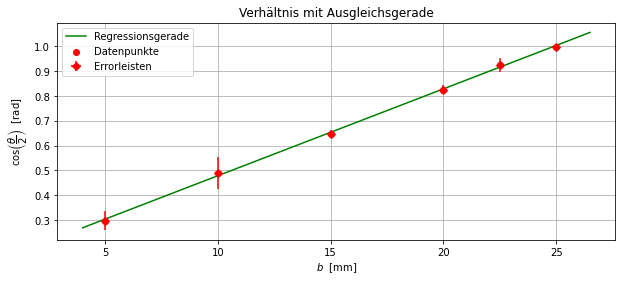

In [177]:
# Diagramm cos
fig, ax = plt.subplots(figsize=(10,4))

print(b, cos_theta_am)
ax.scatter(b, cos_theta_am, color='r', label='Datenpunkte')
#ax.errorbar(b_am, cos_theta_am, xerr=b_std, yerr=cos_theta_std, fmt='D', color='#d0740b', label='Errorleisten')
x = np.arange(4, 27, 0.5)

m, c = np.polyfit(b, cos_theta_am, 1)
ax.plot(x,x*m+c,color='g',label="Regressionsgerade")

ax.set(xlabel=r'$b \,\,$ [mm]', ylabel=r'$\cos\left(\dfrac{\theta}{2}\right) \,\,$ [rad]', title='Verhältnis mit Ausgleichsgerade')
ax.errorbar(b, cos_theta_am, xerr=0, yerr=cos_theta_std, fmt='D', color='red', label='Errorleisten')
ax.legend()
ax.grid()
fig.savefig("regress_14.png")

In [138]:
# gauss einzel theta
#r_2_einzel = b[0]/(np.cos((s[0]*pc.pi/s_tot)))-r_1
theta_einzel = (s[0]*2.0*pc.pi)/s_tot

#theta = ((s*2.0*pc.pi)/r_außen*2.0*pc.pi) 
exponenten = np.array([1, -1])
unsicherheiten = np.array([1.0, 1.0])
einzel_fehler = np.array([])
for i in range(15):
    werte = np.array([s[0][i],r_außen])
    ef = einfachGaussMult(unsicherheiten, werte, exponenten)
    einzel_fehler = np.append(einzel_fehler, ef*theta_einzel[i])
#print(einzel_fehler)

# gauss einzel r_2

bi, si, rai, rii = symbols('bi si rai rii')
f = (bi/sy.cos((si/rai)/2))-rii
variablen = np.array([bi, si, rai, rii])
unsicherheiten = np.array([.5, 1.0, 1.0, .05])
einzel_fehler_r = np.array([])

for i in range(15):
    werte = np.array([b[0],s[0][i],r_außen, r_1])
    efr = fehler(f, werte, unsicherheiten, variablen)
    einzel_fehler_r = np.append(einzel_fehler_r, efr)
print(einzel_fehler_r)

[1.46279964386116 1.52252534155862 1.53651815957192 1.59536164077311
 1.61869213192773 1.62663173188077 1.62663173188077 1.63465483903081
 1.65095685855097 1.65923848345894 1.67606996518118 1.77554627985369
 1.86677589057567 2.01756381383736 2.72395487750294]


In [172]:
listi = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
vdict = {"b":[1.0],"5mm": theta[0], "10mm": theta[1], "15mm": theta[2], 
         "20mm": theta[3], "22.5mm": theta[4], "25mm": theta[5]}
deltavdict = {"b":listi,"5mm": listi, "10mm": listi, "15mm": listi, 
              "20mm": listi, "22.5mm": listi, "25mm": listi}
print_to_table(vdict, deltavdict, [r'$\theta_1$',r'$\theta_2$',r'$\theta_3$',r'$\theta_4$',r'$\theta_5$',
                                   r'$\theta_6$',r'$\theta_7$', r'$\theta_8$', r'$\theta_9$',r'$\theta_{10}$',
                                   r'$\theta_{11}$',r'$\theta_{12}$', r'$\theta_{13}$', r'$\theta_{14}$', r'$\theta_{15}$'], 
               ["5mm", "10mm", "15mm", "20mm", "22.5mm", "25mm"], highlight_best=False, )

\begin{tabular}{l c c c c c c} \hline
 & 5mm & 10mm & 15mm & 20mm & 22.5mm & 25mm \\ 
 \hline
$\theta_1$ &
 $2.44 \pm 0.01$ &
 $1.81 \pm 0.01$ &
 $1.60 \pm 0.01$ &
 $1.04 \pm 0.01$ &
 $0.35 \pm 0.01$ &
 $0.12 \pm 0.01$
 \vspace*{0.0mm} \\
$\theta_2$ &
 $2.47 \pm 0.01$ &
 $1.84 \pm 0.01$ &
 $1.72 \pm 0.01$ &
 $1.13 \pm 0.01$ &
 $0.62 \pm 0.01$ &
 $0.12 \pm 0.01$
 \vspace*{0.0mm} \\
$\theta_3$ &
 $2.47 \pm 0.01$ &
 $2.03 \pm 0.01$ &
 $1.72 \pm 0.01$ &
 $1.15 \pm 0.01$ &
 $0.62 \pm 0.01$ &
 $0.12 \pm 0.01$
 \vspace*{0.0mm} \\
$\theta_4$ &
 $2.50 \pm 0.01$ &
 $2.06 \pm 0.01$ &
 $1.72 \pm 0.01$ &
 $1.17 \pm 0.01$ &
 $0.73 \pm 0.01$ &
 $0.12 \pm 0.01$
 \vspace*{0.0mm} \\
$\theta_5$ &
 $2.51 \pm 0.01$ &
 $2.07 \pm 0.01$ &
 $1.72 \pm 0.01$ &
 $1.18 \pm 0.01$ &
 $0.75 \pm 0.01$ &
 $0.12 \pm 0.01$
 \vspace*{0.0mm} \\
$\theta_6$ &
 $2.51 \pm 0.01$ &
 $2.09 \pm 0.01$ &
 $1.72 \pm 0.01$ &
 $1.19 \pm 0.01$ &
 $0.75 \pm 0.01$ &
 $0.12 \pm 0.01$
 \vspace*{0.0mm} \\
$\theta_7$ &
 $2.51 \pm 0.01$ &
 $2.

8.63063063063063

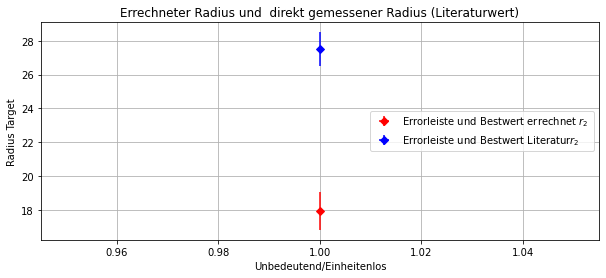

In [206]:
fig, ax = plt.subplots(figsize=(10,4))
x = [1.0]
r_2_g = 27.5 # mm +-1
r_2_g_err = 1
r_2 = 17.92 #mm +- 1.11
r_2_err = 1.11
ax.errorbar(x, r_2, xerr=0, yerr=r_2_err, fmt='D', color='r', label=r'Errorleiste und Bestwert errechnet $ r_2 $ ')
ax.errorbar(x, r_2_g, xerr=0, yerr=r_2_g_err, fmt='D', color='b', label=r'Errorleiste und Bestwert Literatur$ r_2 $ ')

#ax.plot(x, r_2_g, color='b',label=r'direkt gemessener $ r_2 $ ')
#ax.plot(x, r_2_g+1, color='b',label=r'direkt gemessener $ r_2 $ ')
#ax.plot(x, r_2_g-1, color='b',label=r'direkt gemessener $ r_2 $ ')
ax.set(xlabel='Unbedeutend/Einheitenlos', ylabel='Radius Target', title='Errechneter Radius und  direkt gemessener Radius (Literaturwert)')
ax.legend(loc="center right")
ax.grid()
fig.savefig("vergleich_lit_14.png")

vertraeglichkeit(r_2, r_2_g, r_2_err, r_2_g_err)

In [203]:
print(theta_am)
print(theta_std)
print(b)

[2.53646813 2.11180773 1.73124347 1.1968652  0.76969697 0.11598746]
[7.87796424e-02 1.50566596e-01 4.39904527e-02 6.07189420e-02
 1.56075020e-01 1.43648751e-17]
[ 5.  10.  15.  20.  22.5 25. ]


In [204]:
print(cos_theta_am)
print(cos_theta_std)

[0.29776589 0.49111494 0.64801858 0.82586212 0.92419951 0.99831883]
[3.79184474e-02 6.47727170e-02 1.65051069e-02 1.67561244e-02
 2.67371932e-02 2.29838002e-16]
